In [153]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-441792a8-67cc-2747-016d-3021dea55228)
GPU 1: Tesla T4 (UUID: GPU-55df308e-f74f-330c-5c67-322b5a96ef53)


In [154]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2023-12-23 08:43:14--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.1’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.03s   

2023-12-23 08:43:14 (5.31 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.1’ saved [178509/178509]



**Load the data as we want:**

In [155]:
import pandas as pd
df = pd.read_csv('BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv', parse_dates = ['Date'], index_col = ['Date'])
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


**Keep only Bitcoin Prices column and rename it to Price:**

In [156]:
bitcoin_prices = pd.DataFrame(df['Closing Price (USD)']).rename(columns = {'Closing Price (USD)': 'Prices'})
bitcoin_prices.head()

,Prices
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


**Plot our dataframe**

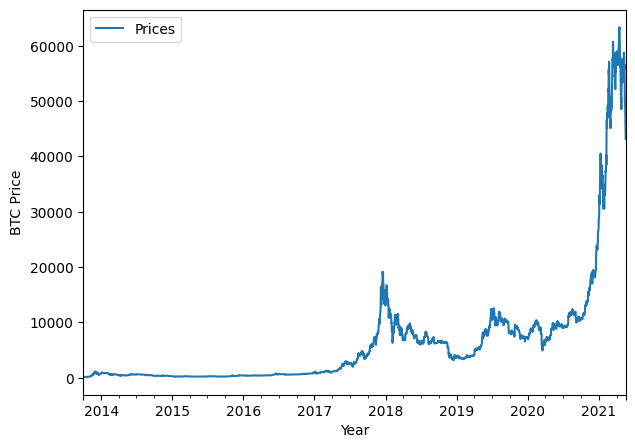

In [157]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize = (7, 5))
plt.xlabel('Year')
plt.ylabel('BTC Price')
plt.legend();

**Separate timesteps and prices columns**

In [158]:
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices['Prices'].to_numpy()

In [159]:
prices

array([  123.65499   ,   125.455     ,   108.58483   , ...,
       47885.62525472, 45604.61575361, 43144.47129086])

**Split into train timesteps, test timesteps, train_prices, test_prices:**

In [160]:
split_size = int(0.8 * len(prices))
timesteps_train, prices_train = timesteps[:split_size], prices[:split_size]
timesteps_test, prices_test = timesteps[split_size:], prices[split_size:]

**Create a function to plot our predictions against true data:**

In [161]:
def plot_time_series(timesteps, values, start, end = None, format = '-', label = None):
    plt.plot(timesteps[start:end], values[start:end], format, label = label)
    plt.xlabel('Year')
    plt.ylabel('BTC Prices')
    if label:
        plt.legend();
    plt.grid(True)

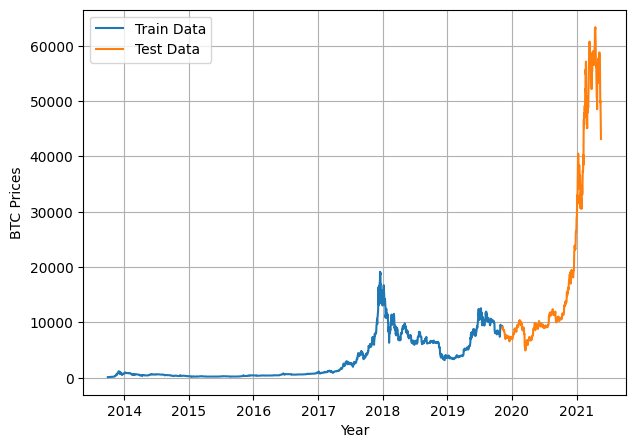

In [162]:
OFFSET = 300
plt.figure(figsize = (7, 5))
plot_time_series(timesteps = timesteps_train, values = prices_train, start = 0, label = 'Train Data')
plot_time_series(timesteps = timesteps_test, values = prices_test, start = 0, label = 'Test Data')

**Create a functrion to find MASE error:**

In [163]:
def mean_absolute_scaled_error(y_true, y_pred):
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))
    
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))
    return mae / mae_naive_no_season

**Create a function to evaluate the results of different models we are going to train:**

In [164]:
def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype = tf.float32)
    y_pred = tf.cast(y_pred, dtype = tf.float32)
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)
    
    if mae.ndim > 0:
        mae = tf.reduce_mean(mae)
        mase = tf.reduce_mean(mse)
        rmse = tf.reduce_mean(rmse)
        mape = tf.reduce_mean(mape)
        mase = tf.reduce_mean(mase)
    return {'mae': mae.numpy(),
            'mse': mase.numpy(),
            'rmse': rmse.numpy(),
            'mape': mape.numpy(),
            'mase': mase.numpy()}

**Create a copy of our bitcoin_prices DataFrame:**

In [165]:
model_data = bitcoin_prices.copy()
model_data.head()

,Prices
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


**Make Windows and Horizons:**

In [166]:
HORIZON = 1
WINDOW_SIZE = 7
for i in range(WINDOW_SIZE):
    model_data[f'Price+{i+1}'] = model_data['Prices'].shift(periods = i + 1)
model_data.dropna().head()

,Prices,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500
2013-10-10,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483
2013-10-11,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466
2013-10-12,125.92750,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866


**Create full windows and full horizons:**

In [167]:
X = model_data.dropna().drop('Prices', axis = 1)
y = model_data.dropna()['Prices']
len(y)

2780

**Make train windows , train labels, test_windows and test_labels:**

In [168]:
split_size = int(0.8 * len(X))
train_windows, train_labels = X[:split_size], y[:split_size]
test_windows, test_labels = X[split_size:], y[split_size:]
len(train_windows), len(train_labels), len(test_windows), len(test_labels)

(2224, 2224, 556, 556)

In [169]:
import tensorflow as tf

**Create our train and test datasets**

In [170]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(train_windows)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(train_labels)
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
train_dataset = train_dataset.batch(128).prefetch(tf.data.AUTOTUNE)
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [171]:
test_features_dataset = tf.data.Dataset.from_tensor_slices(test_windows)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(test_labels)
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))
test_dataset = test_dataset.batch(128).prefetch(tf.data.AUTOTUNE)
test_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

**ModelCheckpoint callback:**

In [172]:
import os
def create_model_callback(model_name, save_path = 'model_experiments'):
    return tf.keras.callbacks.ModelCheckpoint(filepath = os.path.join(save_path, model_name),
                                             verbose = 0,
                                             save_best_only = True,
                                             restore_best_weights = True)

**Model 1: Dense Model:**

In [173]:
tf.random.set_seed(42)
model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(HORIZON, activation = 'linear')
], name = 'Dense_Model')
model_1.compile(loss = 'mae', optimizer = tf.keras.optimizers.Adam(), metrics = ['mae', 'mse'])
model_1.fit(train_dataset,
           epochs = 1000,
           verbose = 0,
           validation_data = test_dataset,
           callbacks = [create_model_callback(model_name = model_1.name)])

In [174]:
model_1.evaluate(test_dataset)

5/5 [==============================] - 0s 3ms/step - loss: 644.7147 - mae: 644.7147 - mse: 1427009.3750


[644.7146606445312, 644.7146606445312, 1427009.375]

In [175]:
model_1 = tf.keras.models.load_model('/kaggle/working/model_experiments/Dense_Model')
model_1.evaluate(test_dataset)

5/5 [==============================] - 0s 3ms/step - loss: 642.8395 - mae: 642.8395 - mse: 1405464.6250


[642.8394775390625, 642.8394775390625, 1405464.625]

In [176]:
def make_preds(model, data):
    forecast = model.predict(data)
    return tf.squeeze(forecast)

In [177]:
model_1_preds = make_preds(model_1, test_dataset)
model_1_preds[:10]

5/5 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([9021.381, 8904.849, 9005.754, 8854.149, 8820.161, 8757.497,
       8749.446, 8586.122, 8543.367, 8544.886], dtype=float32)>

In [178]:
model_results = evaluate_preds(test_labels, model_1_preds)
model_results

{'mae': 642.8395,
 'mse': 1.1292909,
 'rmse': 1185.523,
 'mape': 2.8527358,
 'mase': 1.1292909}

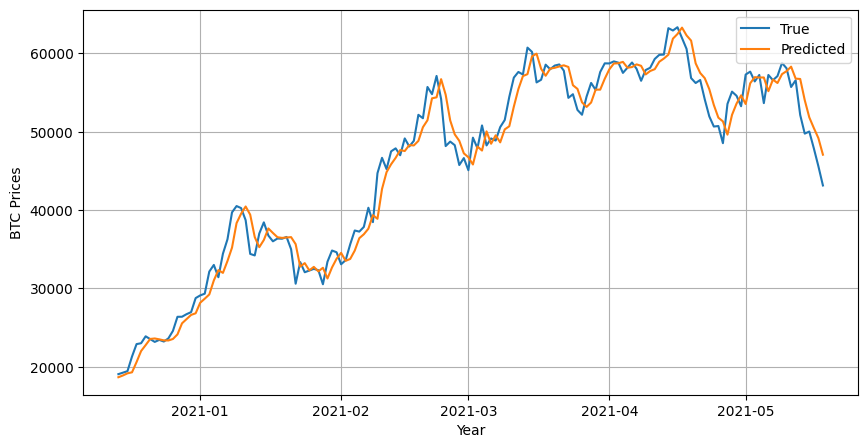

In [179]:
OFFSET = 400
plt.figure(figsize = (10, 5))
plot_time_series(timesteps_test[-len(test_windows):], test_labels, start = OFFSET, label = 'True')
plot_time_series(timesteps_test[-len(test_windows):], model_1_preds, start = OFFSET, label = 'Predicted')

**Model 2 Con1D model:**

In [180]:
tf.random.set_seed(42)
model_2 = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = 1)),
    tf.keras.layers.Conv1D(128, kernel_size = 5, padding = 'causal', activation = 'relu'),
    tf.keras.layers.Dense(HORIZON)
], name = 'CONV1D_Model')
model_2.compile(loss = 'mae', optimizer = tf.keras.optimizers.Adam(), metrics = ['mae', 'mse'])
model_2.fit(train_dataset,
           epochs = 100,
           verbose = 0,
           validation_data = test_dataset,
           callbacks = [create_model_callback(model_name = model_2.name)])

In [181]:
model_2.evaluate(test_dataset)

5/5 [==============================] - 0s 4ms/step - loss: 5015.8804 - mae: 5015.8804 - mse: 89896360.0000


[5015.88037109375, 5015.88037109375, 89896360.0]

In [182]:
model_2 = tf.keras.models.load_model('/kaggle/working/model_experiments/CONV1D_Model')
model_2.evaluate(test_dataset)

5/5 [==============================] - 0s 4ms/step - loss: 5015.8481 - mae: 5015.8481 - mse: 89895432.0000


[5015.84814453125, 5015.84814453125, 89895432.0]

In [183]:
model_2_preds = make_preds(model_2, test_dataset)
model_2_preds[:10]

5/5 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([9004.8955, 8942.831 , 8951.022 , 8849.047 , 8786.116 , 8696.651 ,
       8601.28  , 8567.778 , 8523.167 , 8449.081 ], dtype=float32)>

In [184]:
model_2_results = evaluate_preds(test_labels,
                                 model_2_preds)
model_2_results

{'mae': 1203.8217,
 'mse': 2.1147811,
 'rmse': 2016.1605,
 'mape': 5.335684,
 'mase': 2.1147811}

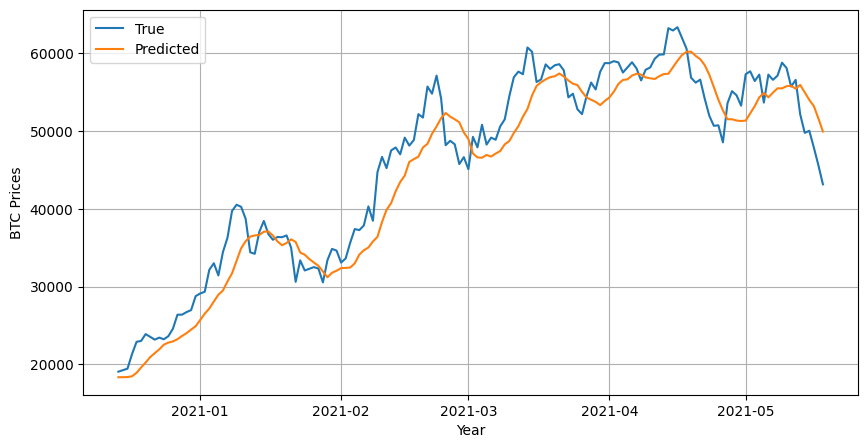

In [185]:
plt.figure(figsize = (10, 5))
plot_time_series(timesteps_test[-len(test_windows):], test_labels, start = OFFSET, label = 'True')
plot_time_series(timesteps_test[-len(test_windows):], model_2_preds, start = OFFSET, label = 'Predicted')

In [186]:
bitcoin_prices.head()

,Prices
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


**Create multivaraite Data:**

In [187]:
import numpy as np
block_reward_1 = 50
block_reward_2 = 25
block_reward_3 = 12.5
block_reward_4 = 6.25

block_reward_2_datetime = np.datetime64('2012-11-28')
block_reward_3_datetime = np.datetime64('2016-07-09')
block_reward_4_datetime = np.datetime64('2020-05-11')

block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days

bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block['block_reward'] = None

bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days : block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4

In [188]:
bitcoin_prices_block.head()

,Prices,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


In [189]:
bitcoin_prices_block[2000:2005]

,Prices,block_reward
Date,,
2019-03-24,3977.707443,12.5
2019-03-25,3968.438701,12.5
2019-03-26,3913.781717,12.5
2019-03-27,3915.375320,12.5
2019-03-28,4018.590510,12.5


In [190]:
bitcoin_prices_block.tail()

,Prices,block_reward
Date,,
2021-05-14,49764.132082,6.25
2021-05-15,50032.693137,6.25
2021-05-16,47885.625255,6.25
2021-05-17,45604.615754,6.25
2021-05-18,43144.471291,6.25


In [191]:
len(bitcoin_prices_block)

2787

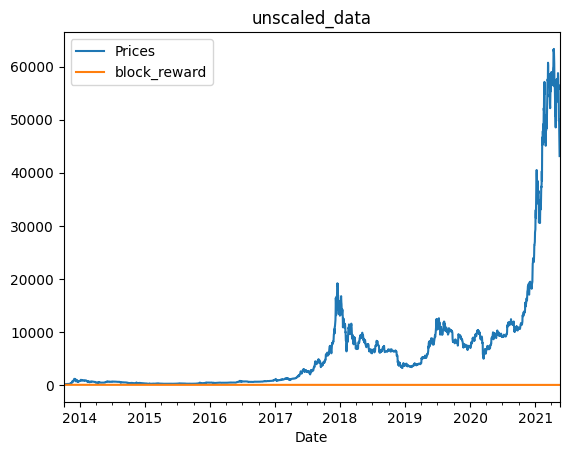

In [192]:
bitcoin_prices_block.plot(title = 'unscaled_data');

**Scale our Multivariate Data:**

In [193]:
from sklearn.preprocessing import minmax_scale
bitcoin_prices_block_scaled = pd.DataFrame(minmax_scale(bitcoin_prices_block[['Prices', 'block_reward']]),
                                          columns = bitcoin_prices_block.columns,
                                          index = bitcoin_prices_block.index)
bitcoin_prices_block_scaled.head()

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


,Prices,block_reward
Date,,
2013-10-01,0.000238,1.0
2013-10-02,0.000267,1.0
2013-10-03,0.000000,1.0
2013-10-04,0.000160,1.0
2013-10-05,0.000202,1.0


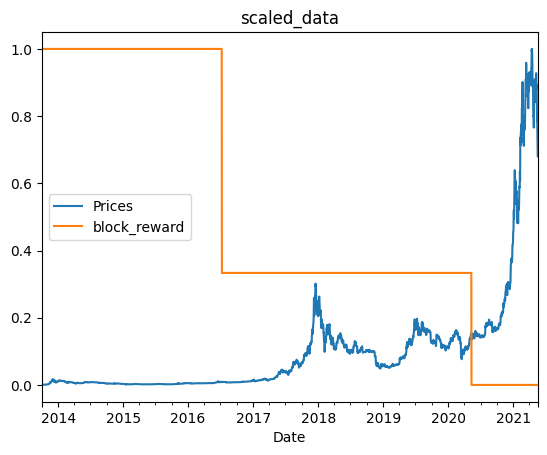

In [194]:
bitcoin_prices_block_scaled.plot(title = 'scaled_data');

In [195]:
HORIZON = 1
WINDOW_SIZE = 7
bitcoin_prices_block_windowed = bitcoin_prices_block.copy()
for i in range(WINDOW_SIZE):
    bitcoin_prices_block_windowed[f'Prices+{i + 1}'] = bitcoin_prices_block_windowed['Prices'].shift(periods = i + 1)
bitcoin_prices_block_windowed.head(10)    

,Prices,block_reward,Prices+1,Prices+2,Prices+3,Prices+4,Prices+5,Prices+6,Prices+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [196]:
X = bitcoin_prices_block_windowed.dropna().drop('Prices', axis = 1).astype(np.float32)
y = bitcoin_prices_block_windowed.dropna()['Prices'].astype(np.float32)

In [197]:
split_size = int(0.8 * len(X))
train_windows, train_labels = X[:split_size], y[:split_size]
test_windows, test_labels = X[split_size:], y[split_size:]
len(train_windows), len(train_labels), len(test_windows), len(test_labels)

(2224, 2224, 556, 556)

In [198]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(train_windows)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(train_labels)
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
train_dataset = train_dataset.batch(128).prefetch(tf.data.AUTOTUNE)
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 8), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [199]:
test_features_dataset = tf.data.Dataset.from_tensor_slices(test_windows)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(test_labels)
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))
test_dataset = test_dataset.batch(128).prefetch(tf.data.AUTOTUNE)
test_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 8), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

**Dense Model with Multivariate Data:**

In [200]:
tf.random.set_seed(42)
model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(HORIZON)
], name = 'multivariate_data_model')
model_3.compile(loss = 'mae', optimizer = tf.keras.optimizers.Adam(), metrics = ['mae', 'mse'])
model_3.fit(train_dataset,
           epochs = 100,
           verbose = 0,
           validation_data = test_dataset,
           callbacks = [create_model_callback(model_name = model_3.name)])

In [201]:
model_3.evaluate(test_dataset)

5/5 [==============================] - 0s 3ms/step - loss: 968.0235 - mae: 968.0235 - mse: 3107278.7500


[968.0234985351562, 968.0234985351562, 3107278.75]

In [202]:
model_3 = tf.keras.models.load_model('/kaggle/working/model_experiments/multivariate_data_model')
model_3.evaluate(test_dataset)

5/5 [==============================] - 0s 3ms/step - loss: 968.0235 - mae: 968.0235 - mse: 3107278.7500


[968.0234985351562, 968.0234985351562, 3107278.75]

In [203]:
model_3_preds = make_preds(model_3, test_dataset)
model_3_preds[:10]

5/5 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([9316.649, 9238.707, 9197.064, 9056.966, 9037.579, 8991.133,
       8857.107, 8838.081, 8782.638, 8704.852], dtype=float32)>

In [204]:
model_3_results = evaluate_preds(test_labels, model_3_preds)
model_3_results

{'mae': 968.0235,
 'mse': 1.7005491,
 'rmse': 1762.7476,
 'mape': 4.3311353,
 'mase': 1.7005491}

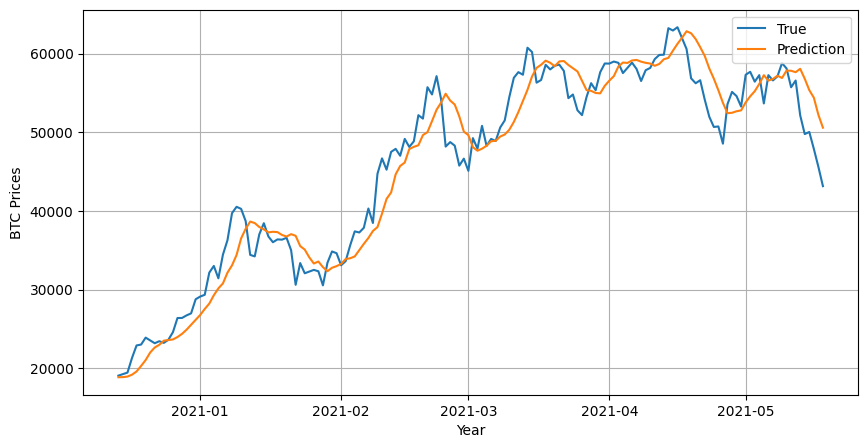

In [205]:
plt.figure(figsize = (10, 5))
plot_time_series(timesteps_test[-len(test_windows):], test_labels, start = OFFSET, label = 'True')
plot_time_series(timesteps_test[-len(test_windows):], model_3_preds, start = OFFSET, label = 'Prediction')

**NBeats Model:**

In [206]:
class NBeatsBlock(tf.keras.layers.Layer):
    def __init__(self, 
                 input_size: int,  
                 theta_size: int,  
                 horizon: int, 
                 n_neurons: int, 
                 n_layers: int, 
                 **kwargs):
        super().__init__(**kwargs)
        self.input_size = input_size
        self.theta_size = theta_size
        self.horizon = horizon
        self.n_neurons = n_neurons
        self.n_layers = n_layers
        self.hidden = [tf.keras.layers.Dense(n_neurons, activation = 'relu') for _ in range(n_layers)]
        self.theta_layer = tf.keras.layers.Dense(theta_size, activation = 'linear', name = 'theta')
    def call(self, inputs):
        x = inputs
        for layer in self.hidden:
            x = layer(x)
        theta = self.theta_layer(x)
        backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
        return backcast, forecast

In [207]:
bitcoin_price_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
    bitcoin_price_nbeats[f'Prices+{i+1}'] = bitcoin_price_nbeats['Prices'].shift(periods = i +1)
bitcoin_price_nbeats.head(10)

,Prices,Prices+1,Prices+2,Prices+3,Prices+4,Prices+5,Prices+6,Prices+7
Date,,,,,,,,
2013-10-01,123.65499,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [208]:
X = bitcoin_price_nbeats.dropna().drop('Prices', axis = 1)
y = bitcoin_price_nbeats.dropna()['Prices']

In [209]:
split_size = int(0.8 * len(X))
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
train_dataset = train_dataset.batch(1024).prefetch(tf.data.AUTOTUNE)
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [210]:
test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))
test_dataset = test_dataset.batch(1024).prefetch(tf.data.AUTOTUNE)
test_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [211]:
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = WINDOW_SIZE + HORIZON

In [212]:
INPUT_SIZE

7

**Set up our Stacking Model:**

In [213]:
%%time

tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = tf.keras.layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link, thank you to: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/174 
residuals = tf.keras.layers.subtract([stack_input, backcast], name=f"subtract_00") 

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = tf.keras.layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = tf.keras.layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
nbeats_model = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_7_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
nbeats_model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
nbeats_model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])



Epoch 211: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 311: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
CPU times: user 1min 46s, sys: 2.72 s, total: 1min 49s
Wall time: 1min 49s


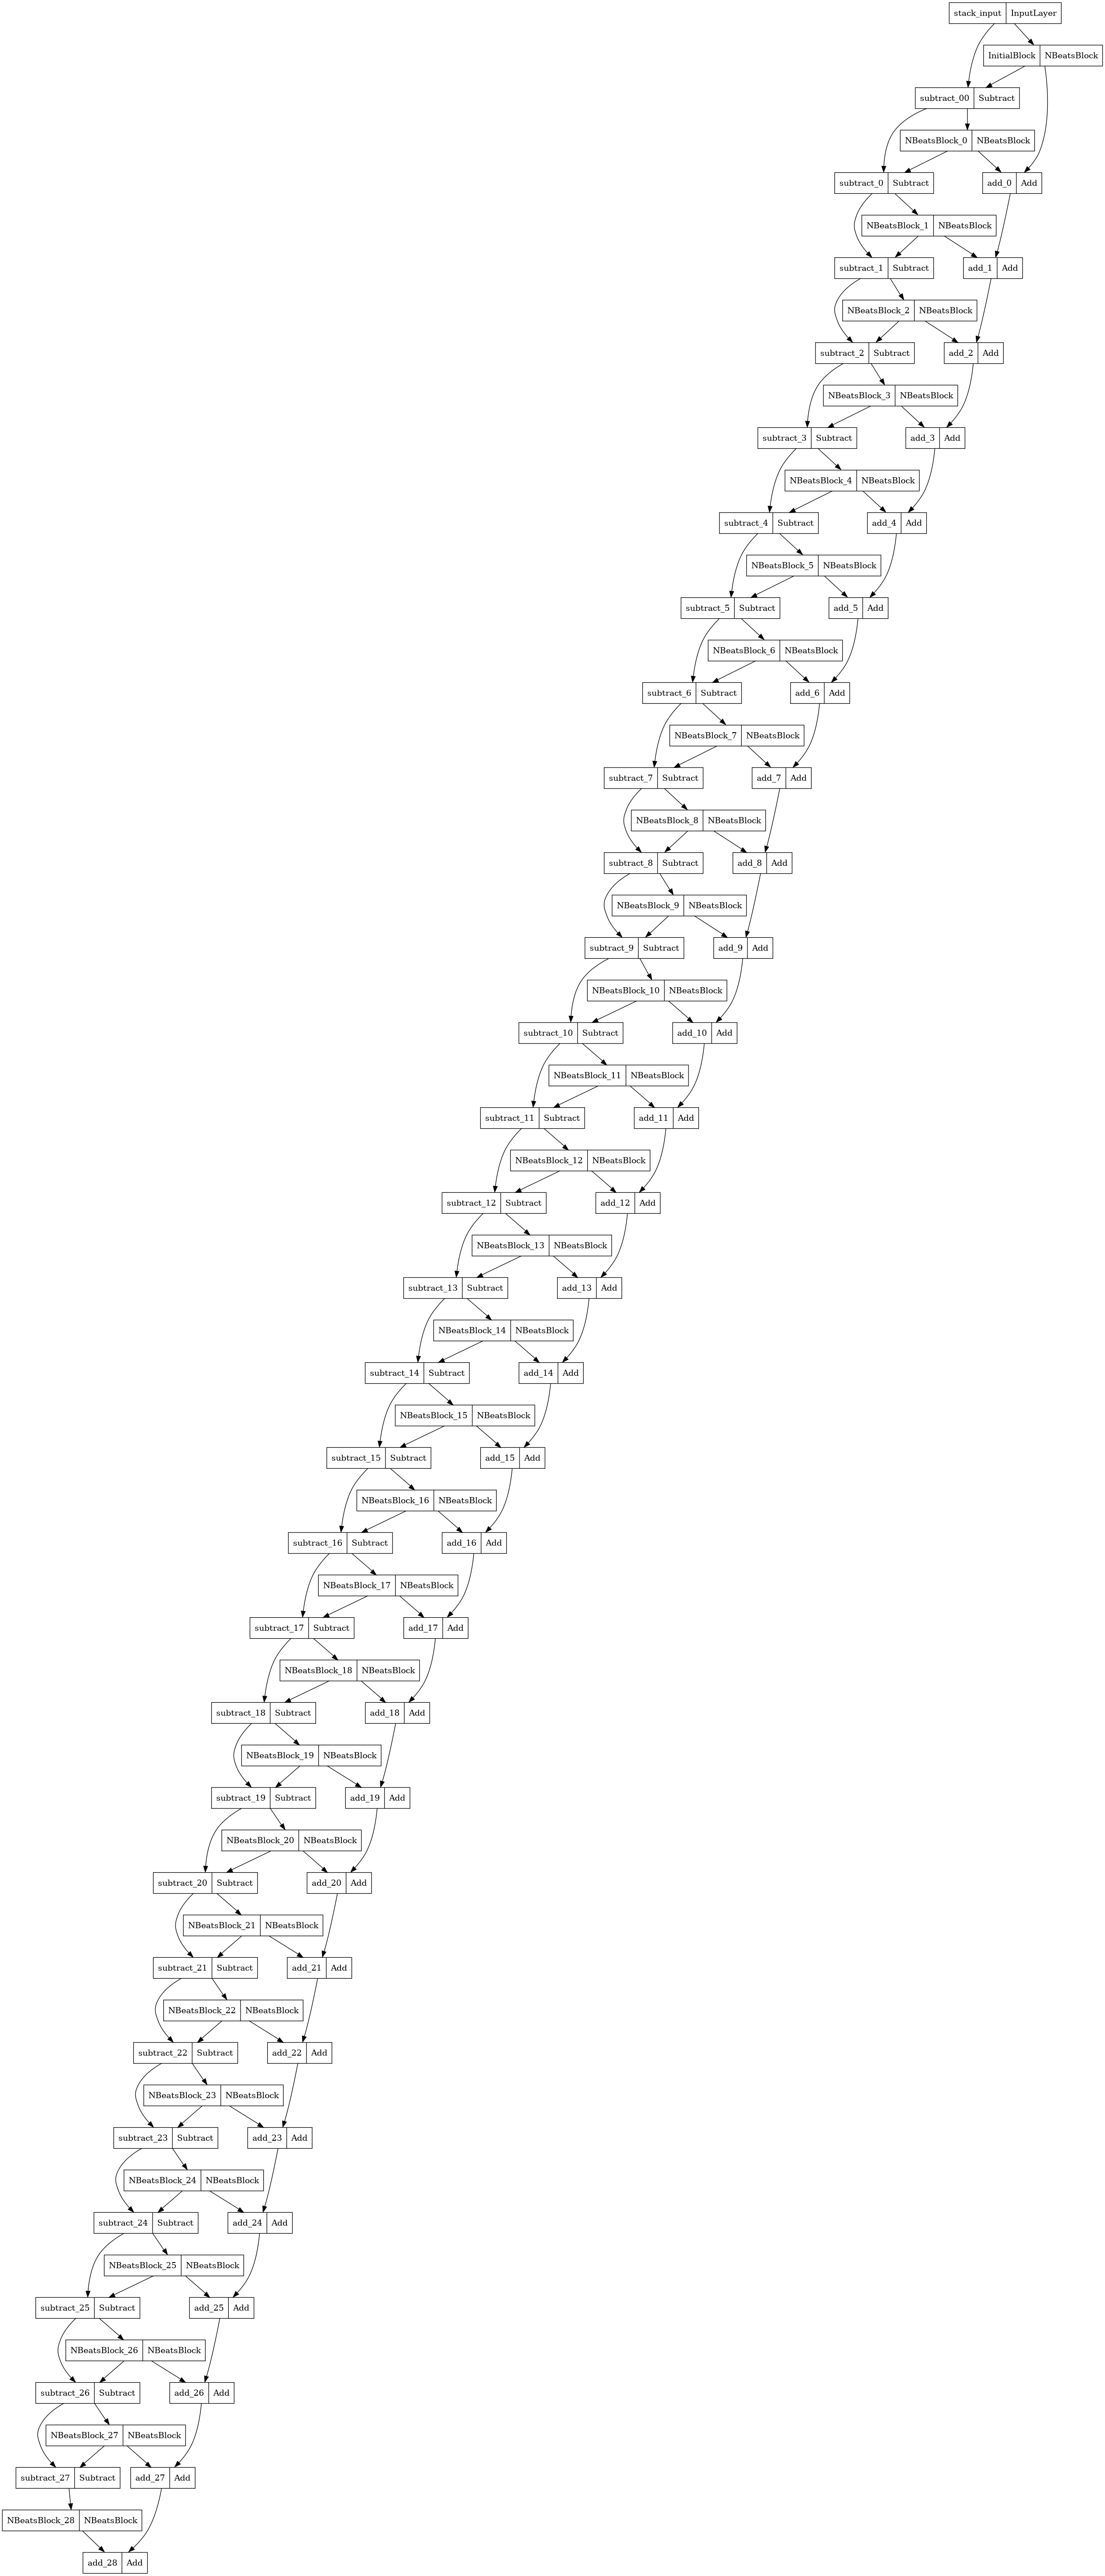

In [214]:
from keras.utils import plot_model
plot_model(nbeats_model)

In [215]:
nbeats_model.evaluate(test_dataset)

1/1 [==============================] - 0s 34ms/step - loss: 573.9344 - mae: 573.9344 - mse: 1178224.1250


[573.9344482421875, 573.9344482421875, 1178224.125]

In [216]:
nbeats_model_preds = make_preds(nbeats_model, test_dataset)
nbeats_model_preds[:10]

1/1 [==============================] - 1s 1s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8909.823, 8818.78 , 9035.076, 8787.2  , 8751.676, 8760.792,
       8673.243, 8523.45 , 8499.533, 8527.808], dtype=float32)>

In [217]:
nbeats_model_results = evaluate_preds(test_labels, nbeats_model_preds)
nbeats_model_results

{'mae': 573.93445,
 'mse': 1.0082439,
 'rmse': 1085.4603,
 'mape': 2.5843556,
 'mase': 1.0082439}

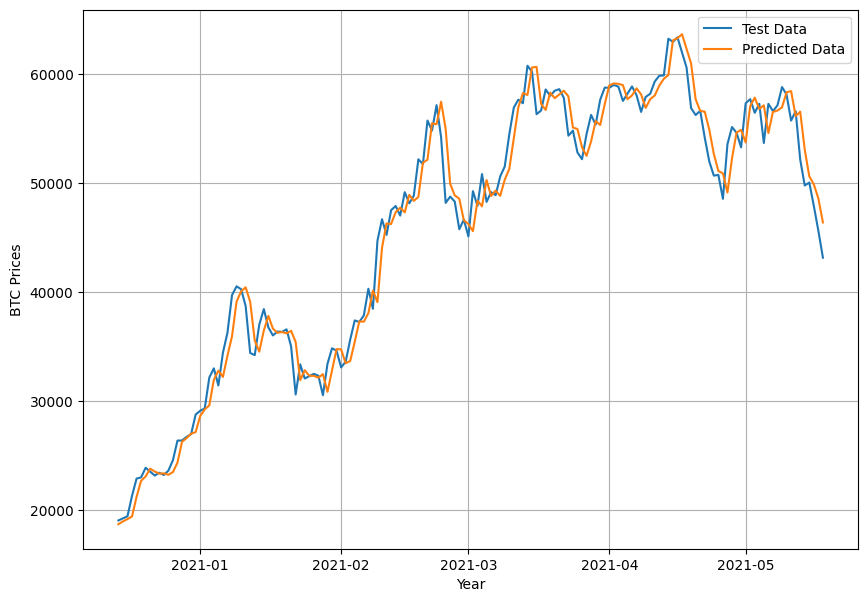

In [218]:
plt.figure(figsize = (10, 7))
plot_time_series(timesteps_test[-len(test_windows):], y_test, start = OFFSET, label = 'Test Data')
plot_time_series(timesteps_test[-len(test_windows):], nbeats_model_preds, start = OFFSET, label = 'Predicted Data')

**Create a function for getting our Ensemble Models:**

In [219]:
def get_ensemble_models(horizon = HORIZON,
                        train_data = train_dataset,
                        test_data = test_dataset,
                        num_iter = 10,
                        num_epochs = 100,
                        loss_fns = ['mae', 'mse', 'mape']):
    ensemble_models = []
    for i in range(num_iter):
        for loss_function in loss_fns:
            print(f"Optimizing model by reducing {loss_function} for {num_epochs}, model number = {i}")
            model = tf.keras.Sequential([
                tf.keras.layers.Dense(128, kernel_initializer = 'he_normal', activation = 'relu'),
                tf.keras.layers.Dense(128, kernel_initializer = 'he_normal', activation = 'relu'),
                tf.keras.layers.Dense(HORIZON)
            ])
            model.compile(loss = loss_function, optimizer = tf.keras.optimizers.Adam(), metrics = ['mae', 'mse'])
            model.fit(train_data,
                     epochs = num_epochs,
                     validation_data = test_data,
                     verbose = 0,
                     callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 200, restore_best_weights = True),
                                  tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', patience = 100, verbose = 1)])
            ensemble_models.append(model)
    return ensemble_models

**Get our ensemble models:**

In [220]:
ensemble_models = get_ensemble_models(num_iter = 5,
                                     num_epochs = 1000)

Optimizing model by reducing mae for 1000, model number = 0
Optimizing model by reducing mse for 1000, model number = 0

Epoch 195: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 295: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing mape for 1000, model number = 0

Epoch 110: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 644: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 762: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 862: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 962: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
Optimizing model by reducing mae for 1000, model number = 1

Epoch 795: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 895: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing mse for 100

In [221]:
for model in ensemble_models:
    model.evaluate(test_dataset)

1/1 [==============================] - 0s 12ms/step - loss: 2.5999 - mae: 567.4666 - mse: 1151714.5000


In [222]:
len(ensemble_models)

15

**Create a funtion to make predictions through our ensemble model:**

In [223]:
def make_ensemble_preds(ensemble_models, data):
    ensemble_preds = []
    for model in ensemble_models:
        preds = model.predict(data)
        ensemble_preds.append(preds)
    return tf.constant(tf.squeeze(ensemble_preds))

In [224]:
ensemble_preds = make_ensemble_preds(ensemble_models, test_dataset)
ensemble_preds[:3]

1/1 [==============================] - 0s 46ms/step


<tf.Tensor: shape=(3, 556), dtype=float32, numpy=
array([[ 8694.54 ,  8749.776,  8940.649, ..., 49118.074, 47951.113,
        46425.832],
       [ 8765.568,  8745.915,  9001.529, ..., 49803.375, 47424.52 ,
        45628.22 ],
       [ 8805.802,  8795.161,  9033.519, ..., 50125.098, 47675.64 ,
        46936.23 ]], dtype=float32)>

In [225]:
ensemble_models_results = evaluate_preds(test_labels, ensemble_preds)
ensemble_models_results

{'mae': 583.0719,
 'mse': 1185938.0,
 'rmse': 1088.9324,
 'mape': 2.6730206,
 'mase': 1185938.0}

**Create a function to get upper and lower bounds:**

In [226]:
ensemble_median = np.median(ensemble_preds, axis = 0)
def get_lower_upper(preds):
    std = tf.math.reduce_std(preds, axis = 0)
    interval = 1.96 * std
    preds_mean = tf.reduce_mean(preds, axis = 0)
    lower, upper = preds_mean - interval, preds_mean + interval
    return lower, upper

In [227]:
lower, upper = get_lower_upper(ensemble_preds)
lower, upper

(<tf.Tensor: shape=(556,), dtype=float32, numpy=
 array([ 8712.944 ,  8663.431 ,  8974.932 ,  8642.044 ,  8673.869 ,
         8613.331 ,  8574.2705,  8398.828 ,  8361.009 ,  8462.476 ,
         8138.209 ,  8026.9375,  7962.6235,  7535.276 ,  7201.8647,
         7211.4233,  6960.028 ,  7101.399 ,  7045.222 ,  7407.284 ,
         7313.2705,  7635.153 ,  7496.9116,  7308.2407,  7242.7017,
         7236.7925,  7124.693 ,  7323.2554,  7433.2046,  7471.037 ,
         7497.793 ,  7277.123 ,  7171.3164,  7120.0225,  7118.7217,
         7181.323 ,  7024.0933,  7049.4824,  6806.1367,  6517.7866,
         7301.8765,  7039.833 ,  7023.5303,  7163.8623,  7144.4434,
         7086.6084,  7164.6333,  7160.9263,  7128.9385,  7169.8813,
         7255.625 ,  7335.7153,  7186.6255,  7124.967 ,  7124.2817,
         6887.287 ,  7217.5767,  7249.2207,  7282.4087,  7648.8267,
         7950.331 ,  8060.6157,  7750.442 ,  8052.9644,  8045.8286,
         8099.863 ,  8023.295 ,  8617.073 ,  8800.411 ,  8682.004 ,

**Plot the prediction intervals:**

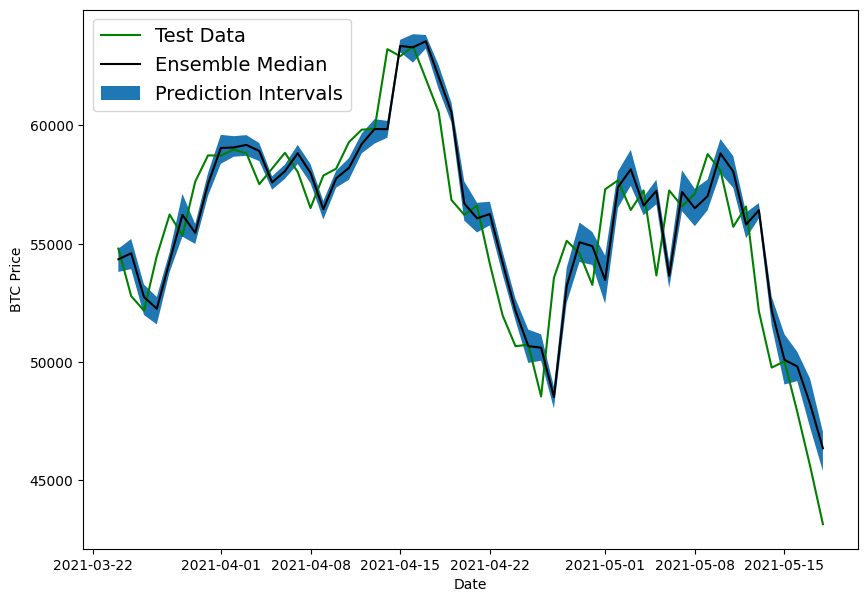

In [228]:
OFFSET = 500
plt.figure(figsize = (10, 7))
plt.plot(X_test.index[OFFSET:], y_test[OFFSET:], "g", label="Test Data")
plt.plot(X_test.index[OFFSET:], ensemble_median[OFFSET:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.fill_between(X_test.index[OFFSET:], (lower)[OFFSET:], (upper)[OFFSET:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);

In [229]:
HORIZON = 1
WINDOW_SIZE = 7
bitcoin_prices_block_windowed.head()

,Prices,block_reward,Prices+1,Prices+2,Prices+3,Prices+4,Prices+5,Prices+6,Prices+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [230]:
bitcoin_prices_block_windowed.tail()

,Prices,block_reward,Prices+1,Prices+2,Prices+3,Prices+4,Prices+5,Prices+6,Prices+7
Date,,,,,,,,,
2021-05-14,49764.132082,6.25,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672,56583.849879
2021-05-15,50032.693137,6.25,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672
2021-05-16,47885.625255,6.25,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679
2021-05-17,45604.615754,6.25,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426
2021-05-18,43144.471291,6.25,45604.615754,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651


In [231]:
X_all = bitcoin_prices_block_windowed.dropna().drop(['Prices', 'block_reward'], axis = 1).to_numpy()
y_all = bitcoin_prices_block_windowed.dropna()['Prices'].to_numpy()
len(X_all), len(y_all)

(2780, 2780)

In [232]:
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))
BATCH_SIZE = 1024
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
dataset_all

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [233]:
tf.random.set_seed(42)
future_predictor_model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(HORIZON)
], name = 'future_predictor_model')
future_predictor_model.compile(loss = 'mae', optimizer = tf.keras.optimizers.Adam(), metrics = ['mae', 'mse'])
future_predictor_model.fit(dataset_all,
                          epochs = 100,
                          verbose = 0)

In [234]:
INTO_FUTURE = 14

In [235]:
def make_future_forecasts(values, model, into_future, window_size = WINDOW_SIZE) -> list:
    future_forecast = []
    last_window = values[-WINDOW_SIZE:]
    for _ in range(INTO_FUTURE):
        future_pred = model.predict(tf.expand_dims(last_window, axis = 0))
        print(f"Predicting on:\n{last_window}\n-> Prediction: {tf.squeeze(future_pred).numpy()}")
        future_forecast.append(tf.squeeze(future_pred).numpy())
        last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
    return future_forecast    

In [236]:
future_forecast = make_future_forecasts(values = y_all, model = future_predictor_model, into_future = INTO_FUTURE, window_size = WINDOW_SIZE)

1/1 [==============================] - 0s 56ms/step
Predicting on:
[56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086]
-> Prediction: 55134.74609375
1/1 [==============================] - 0s 20ms/step
Predicting on:
[52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 55134.74609375]
-> Prediction: 49852.56640625
1/1 [==============================] - 0s 18ms/step
Predicting on:
[49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 55134.74609375 49852.56640625]
-> Prediction: 50221.04296875
1/1 [==============================] - 0s 20ms/step
Predicting on:
[50032.69313676 47885.62525472 45604.61575361 43144.47129086
 55134.74609375 49852.56640625 50221.04296875]
-> Prediction: 47363.06640625
1/1 [==============================] - 0s 20ms/step
Predicting on:
[47885.62525472 45604.61575361 43144.47129086 55134.74609375
 49852.56640625 50221.04296875 47363.06640625]
-> Pr

In [237]:
def get_future_dates(start_date, into_future, offset = 1):
    start_date = start_date + np.timedelta64(offset, 'D')
    end_date = start_date + np.timedelta64(into_future, 'D')
    return np.arange(start_date, end_date, dtype = 'datetime64[D]')

In [238]:
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2021-05-18 00:00:00')

In [239]:
next_time_steps = get_future_dates(start_date = last_timestep, into_future = INTO_FUTURE)
next_time_steps

array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01'], dtype='datetime64[D]')

In [240]:
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, prices[-1])

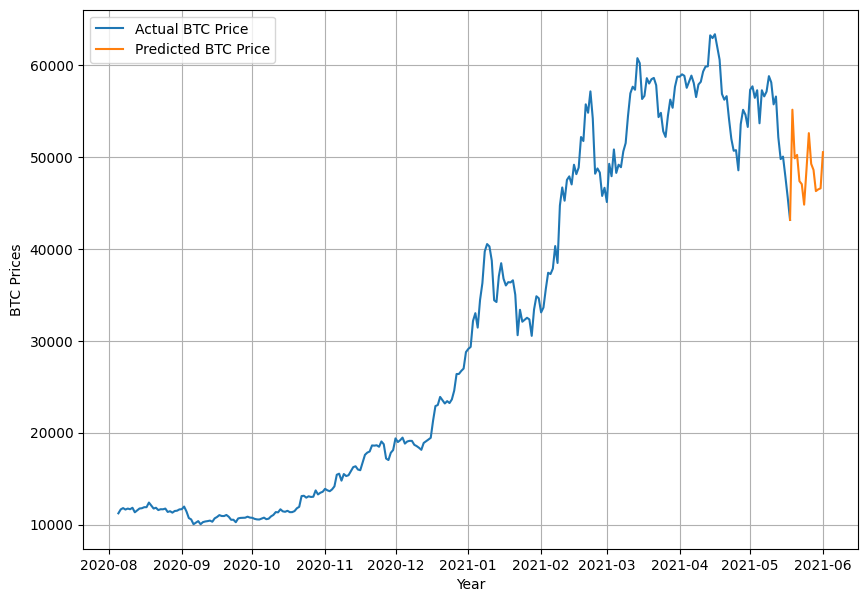

In [241]:
plt.figure(figsize = (10, 7))
plot_time_series(bitcoin_prices.index, prices, start = 2500, format = '-', label = 'Actual BTC Price')
plot_time_series(next_time_steps, future_forecast, start = 0, format = '-', label = 'Predicted BTC Price')

**Introducing the turkey problem:**

In [242]:
bitcoin_prices_turkey = prices.copy()
bitcoin_prices_turkey[-1] = bitcoin_prices_turkey[-1] / 100

In [243]:
bitcoin_prices_turkey[-10:]

array([58788.20967893, 58102.19142623, 55715.54665129, 56573.5554719 ,
       52147.82118698, 49764.1320816 , 50032.69313676, 47885.62525472,
       45604.61575361,   431.44471291])

In [244]:
bitcoin_timesteps_turkey = bitcoin_prices.index
bitcoin_timesteps_turkey[-10:]

DatetimeIndex(['2021-05-09', '2021-05-10', '2021-05-11', '2021-05-12',
               '2021-05-13', '2021-05-14', '2021-05-15', '2021-05-16',
               '2021-05-17', '2021-05-18'],
              dtype='datetime64[ns]', name='Date', freq=None)

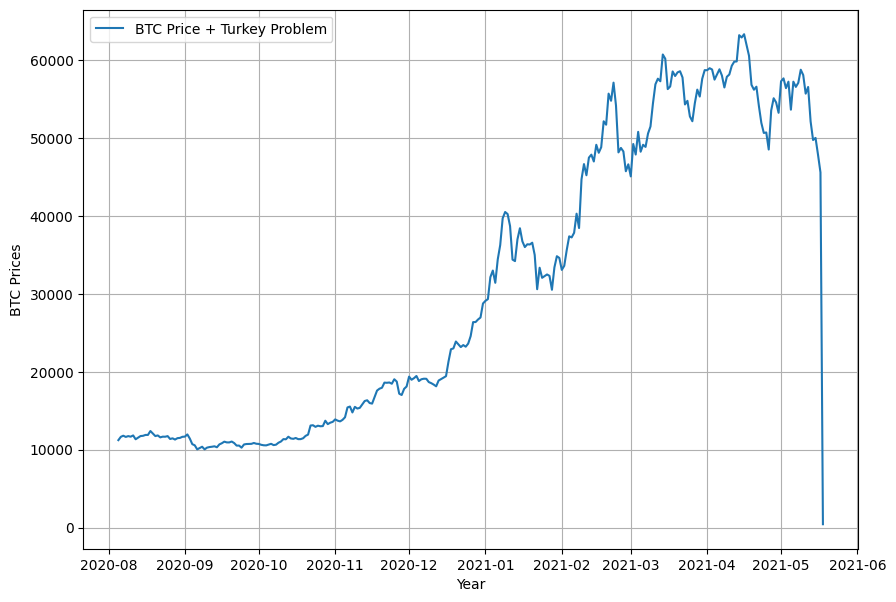

In [245]:
plt.figure(figsize = (10, 7))
plot_time_series(bitcoin_timesteps_turkey, bitcoin_prices_turkey, start = 2500, format = '-', label = 'BTC Price + Turkey Problem')

In [279]:
def get_labelled_windows(x, horizon = 1):
    return x[:, :-horizon], x[:, -horizon:]  

In [284]:
def make_windows(x, window_size = 7, horizon = 1):
    window_step = np.expand_dims(np.arange(window_size + horizon), axis = 0)
    window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon - 1)), axis = 0).T
    windowed_array = x[window_indexes]
    windows, labels = get_labelled_windows(windowed_array, horizon = horizon)
    return windows, labels

In [287]:
full_windows, full_labels = make_windows(np.array(bitcoin_prices_turkey), window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)
split_size = int(0.8 * len(full_windows))
X_train, y_train = full_windows[:split_size], full_labels[:split_size]
X_test, y_test = full_windows[split_size:], full_labels[split_size:]

In [288]:
tf.random.set_seed(42)
turkey_model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(HORIZON)
], name = 'Turkey_Model')
turkey_model.compile(loss = tf.keras.losses.mae, optimizer = tf.keras.optimizers.Adam(), metrics = ['mae', 'mse'])
turkey_model.fit(X_train, y_train, epochs = 100, verbose = 0, validation_data = (X_test, y_test), callbacks = create_model_callback(model_name = turkey_model.name))

In [289]:
turkey_model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 738.5970 - mae: 738.5970 - mse: 4951793.5000


[738.5969848632812, 738.5969848632812, 4951793.5]

In [290]:
turkey_model = tf.keras.models.load_model('/kaggle/working/model_experiments/Turkey_Model')
turkey_model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 641.4869 - mae: 641.4869 - mse: 4870266.5000


[641.4868774414062, 641.4868774414062, 4870266.5]

In [291]:
turkey_model_preds = make_preds(turkey_model, X_test)
turkey_model_preds[-10:]

18/18 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([57006.668, 58628.73 , 58346.46 , 56080.66 , 56290.582, 52705.28 ,
       50077.113, 49649.605, 48359.027, 45964.3  ], dtype=float32)>

In [292]:
turkey_model_result = evaluate_preds(y_test, turkey_model_preds)
turkey_model_result

{'mae': 17129.154,
 'mse': 614344800.0,
 'rmse': 23712.047,
 'mape': 121.3528,
 'mase': 614344800.0}

In [293]:
y_test[:10]

array([[8798.04205463],
       [9081.18687849],
       [8711.53433917],
       [8760.89271814],
       [8749.52059102],
       [8656.97092235],
       [8500.64355816],
       [8469.2608989 ],
       [8537.33965197],
       [8205.80636599]])

In [294]:
turkey_model_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8832.929, 8762.518, 9041.712, 8764.595, 8707.405, 8735.893,
       8674.509, 8506.596, 8444.08 , 8526.176], dtype=float32)>

In [276]:
y_test[-1]

431.44471290860304

In [278]:
turkey_model_preds[-1]

<tf.Tensor: shape=(), dtype=float32, numpy=45942.375>

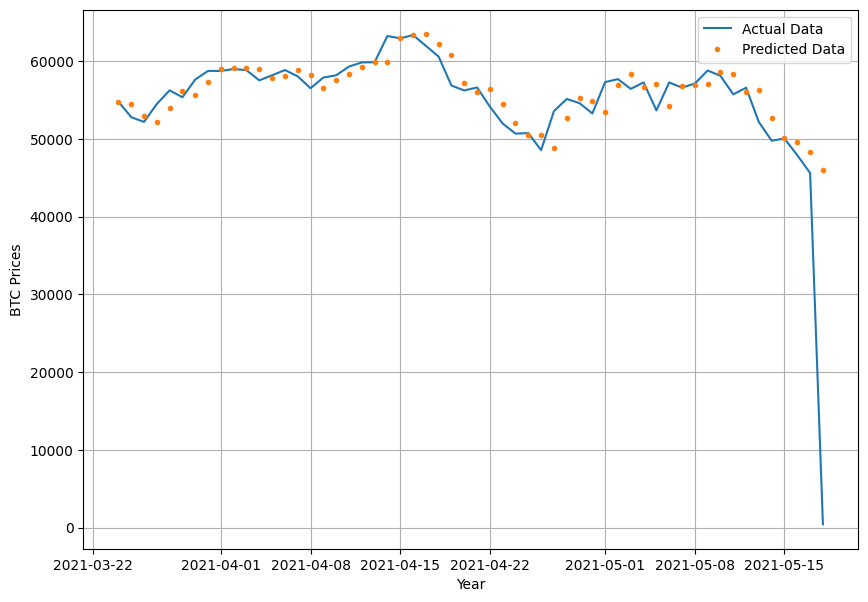

In [299]:
plt.figure(figsize = (10,7))
plot_time_series(bitcoin_timesteps_turkey[-len(X_test):], bitcoin_prices_turkey[-len(y_test):], start = OFFSET, label  = 'Actual Data')
plot_time_series(bitcoin_timesteps_turkey[-len(X_test):], turkey_model_preds, start = OFFSET, label = 'Predicted Data', format = '.')

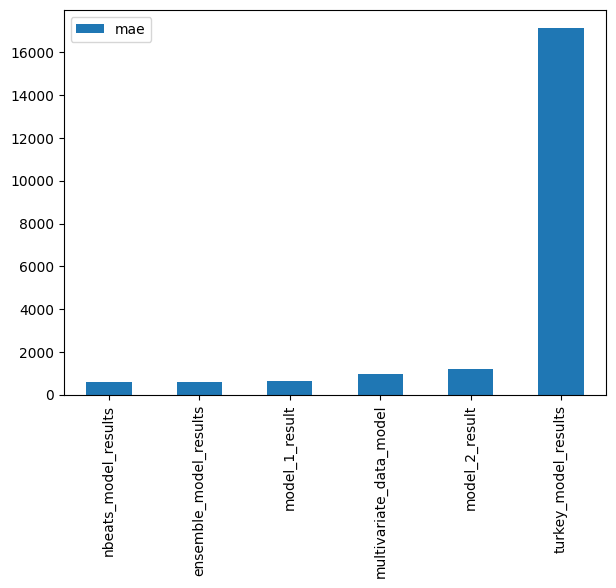

In [305]:
all_model_results = pd.DataFrame({'model_1_result': model_results,
                                 'model_2_result': model_2_results,
                                 'multivariate_data_model': model_3_results,
                                 'nbeats_model_results': nbeats_model_results,
                                 'ensemble_model_results': ensemble_models_results,
                                 'turkey_model_results': turkey_model_result}).T
all_model_results[['mae']].sort_values(by = 'mae').plot(figsize = (7, 5), kind = 'bar');